# Wine Quality Detection Using Random Forests

In [108]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## Downloading the Data

In [31]:
white_df = pd.read_csv("winequality-white.csv", sep = ';')

In [32]:
white_df["color"] = "white"

In [33]:
red_df = pd.read_csv("winequality-red.csv", sep = ';')

In [34]:
red_df["color"] = "red"

In [36]:
# Concatenate red_df and white_df into train_df
train_df = pd.concat([red_df, white_df], ignore_index=True)

In [37]:
train_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


This dataset contains 6497 rows and 13 columns. The column "color" is a categorical column. Our objective is to create a model to predict the value in the "quality" column, which contains an integer score for the wine quality, ranging from 0 to 10.

In [38]:
train_df.info()

print("\n\nMissing Values in every column: ")
train_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Missing Values in every column: 


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64

All of the columns except "color" contain numeric values. Additionally, there are no null values in any of the columns. 

In [39]:
train_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## Exploratory Data Analysis and Visualization

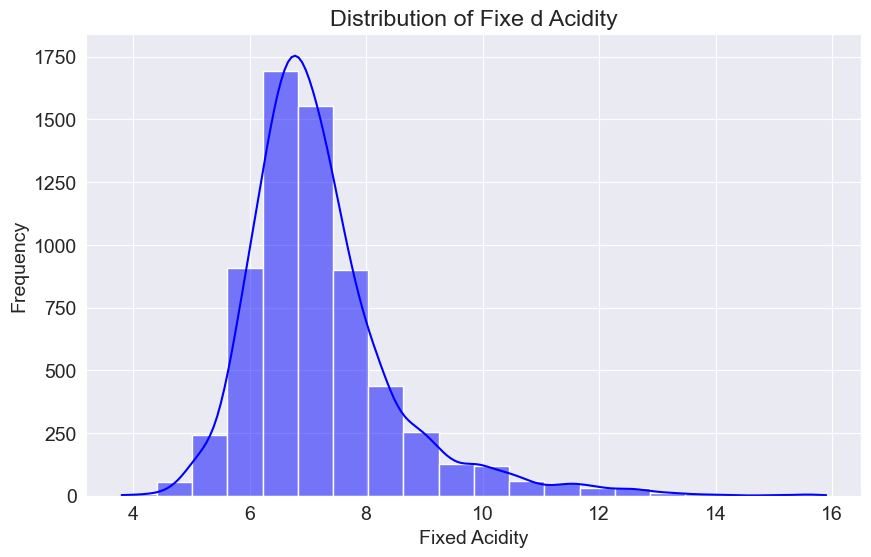

In [40]:
# Histogram for Fixed Acidity
plt.figure(figsize=(10, 6))
sns.histplot(train_df['fixed acidity'], kde=True, color='blue', bins=20)
plt.title('Distribution of Fixe d Acidity')
plt.xlabel('Fixed Acidity')
plt.ylabel('Frequency')
plt.show()

The distribution of fixed acidity appears to be relatively uniform, with the majority of wines having acidity in the mid-range. Some wines exhibit higher acidity, but they are fewer in number.

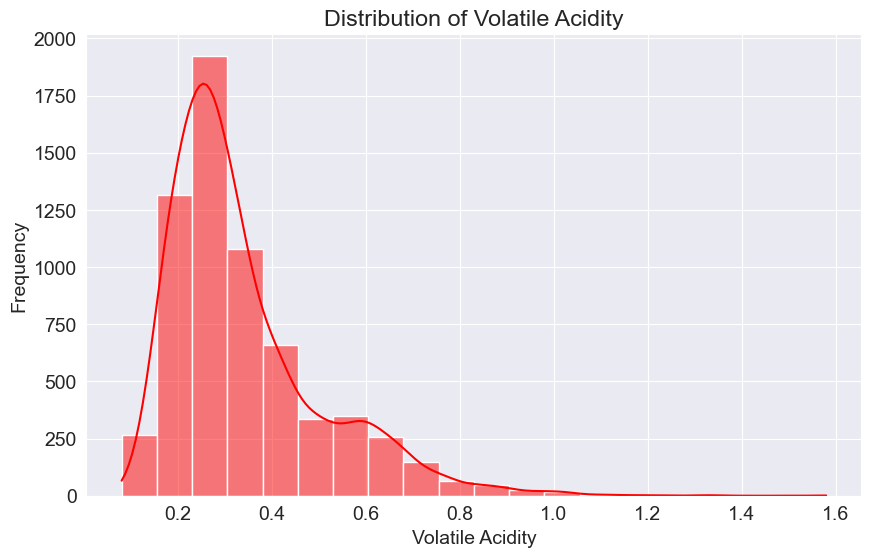

In [41]:
# Histogram for Volatile Acidity
plt.figure(figsize=(10, 6))
sns.histplot(train_df['volatile acidity'], kde=True, color='red', bins=20)
plt.title('Distribution of Volatile Acidity')
plt.xlabel('Volatile Acidity')
plt.ylabel('Frequency')
plt.show()

Volatile acidity is highly skewed, with most wines having lower volatile acidity levels. A high volatile acidity might correlate with poor wine quality or defects.

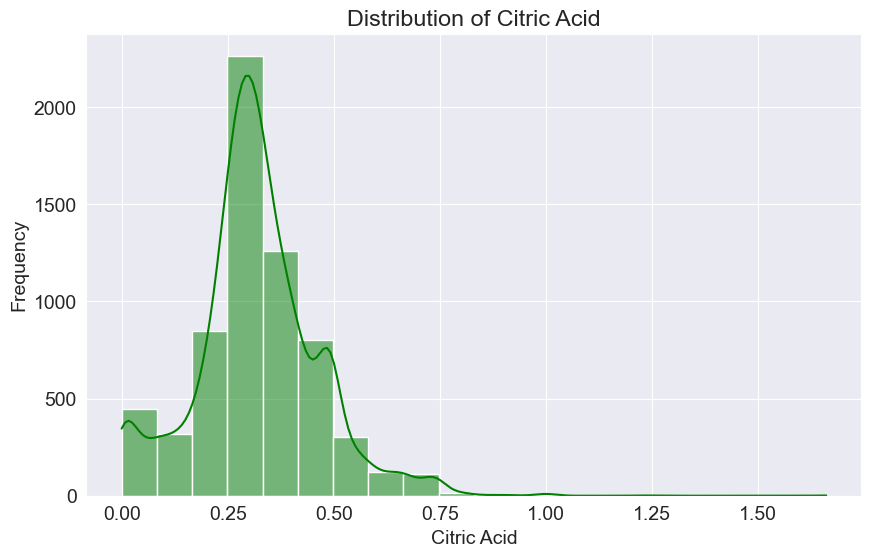

In [42]:
# Histogram for Citric Acid
plt.figure(figsize=(10, 6))
sns.histplot(train_df['citric acid'], kde=True, color='green', bins=20)
plt.title('Distribution of Citric Acid')
plt.xlabel('Citric Acid')
plt.ylabel('Frequency')
plt.show()

Citric acid values are somewhat spread across a range, with a slight peak in the lower range. This might contribute to the overall freshness and balance of the wine, influencing its flavor profile.

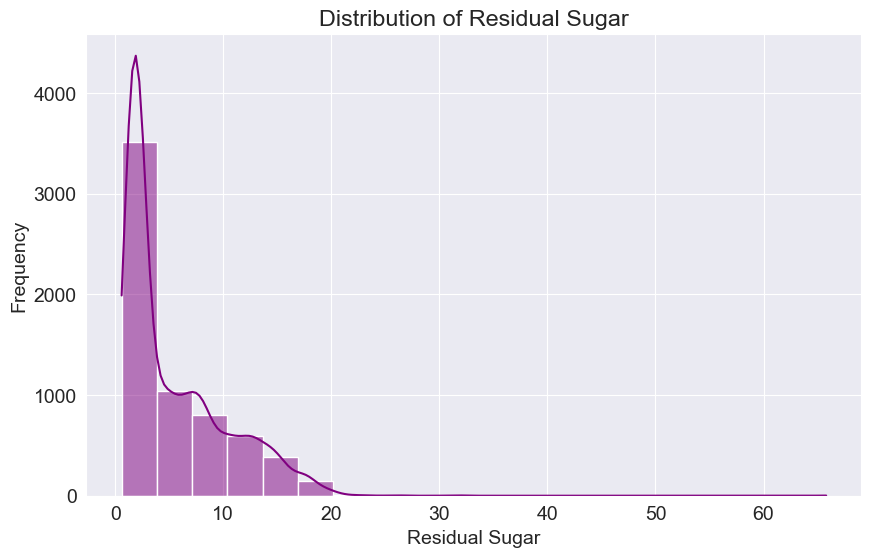

In [43]:
# Histogram for Residual Sugar
plt.figure(figsize=(10, 6))
sns.histplot(train_df['residual sugar'], kde=True, color='purple', bins=20)
plt.title('Distribution of Residual Sugar')
plt.xlabel('Residual Sugar')
plt.ylabel('Frequency')
plt.show()

Most wines have lower residual sugar content, with a few having very high values. Higher residual sugar wines are often sweeter, contributing to the body and texture of the wine.

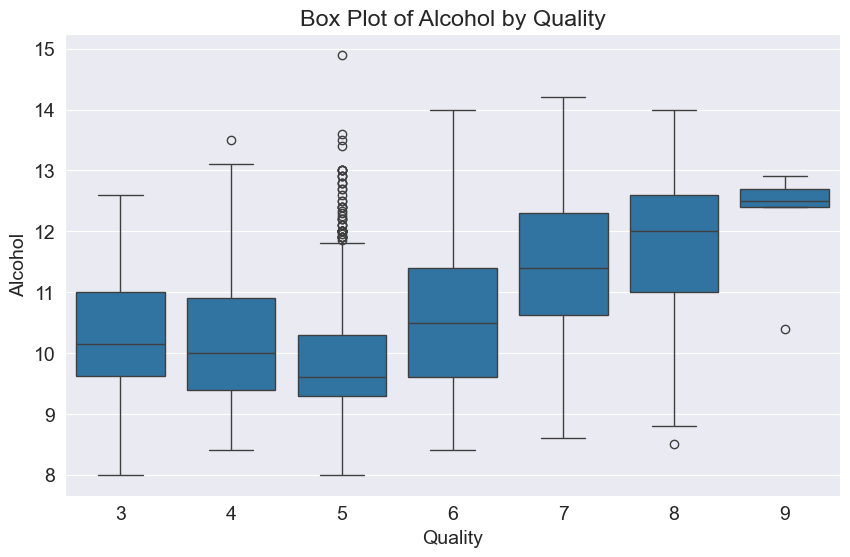

In [45]:
# Box plot for Alcohol by Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='alcohol', data=train_df)
plt.title('Box Plot of Alcohol by Quality')
plt.xlabel('Quality')
plt.ylabel('Alcohol')
plt.show()

Alcohol appears to increase with quality, suggesting that wines with higher alcohol content tend to be of better quality, which could be a result of the fermentation process.

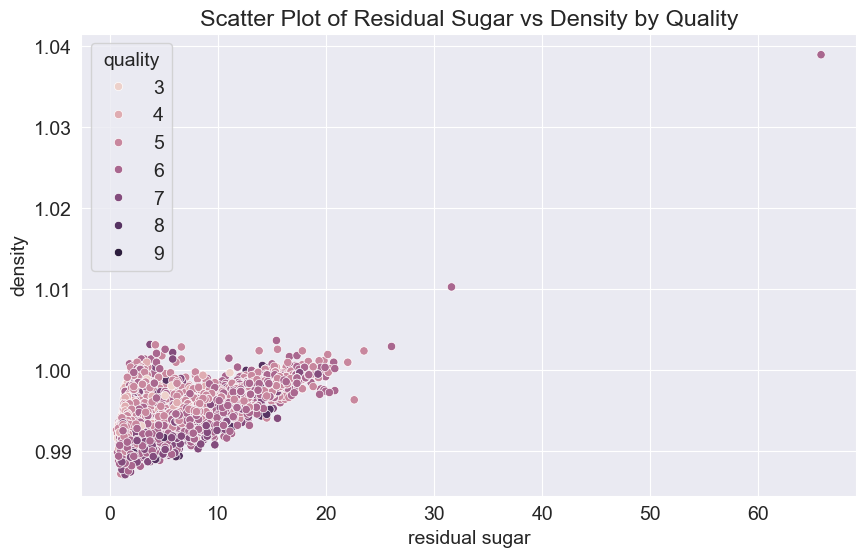

In [46]:
# Scatter Plot for Residual Sugar vs Density by Quality
sns.scatterplot(data=train_df, x="residual sugar", y="density", hue="quality")
plt.title('Scatter Plot of Residual Sugar vs Density by Quality')  
plt.show()

It seems like residual sugar and desnity have a strong positive linear relationship

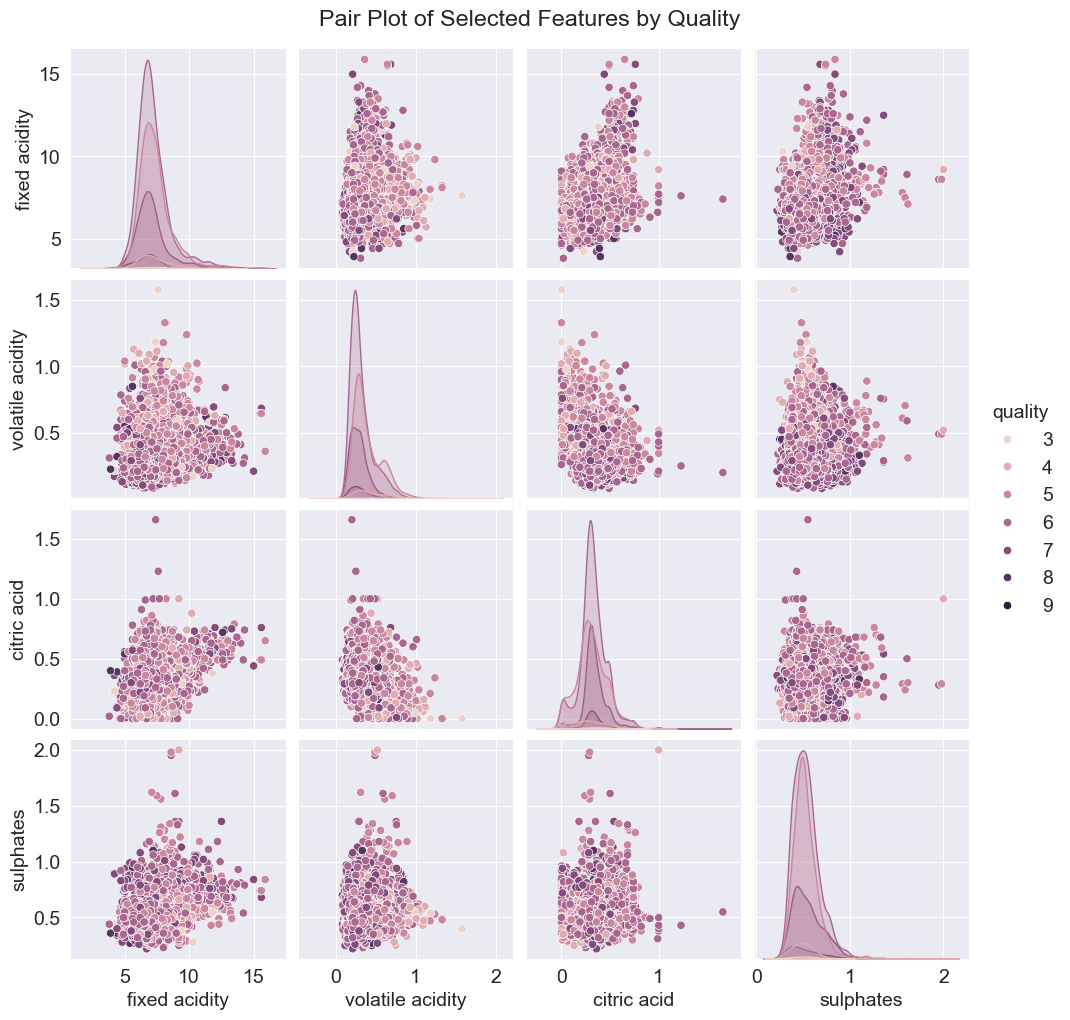

In [47]:
# Pair plot for selected features
sns.pairplot(train_df, vars=['fixed acidity', 'volatile acidity', 'citric acid', 'sulphates'], hue='quality')
plt.suptitle('Pair Plot of Selected Features by Quality', y=1.02)
plt.show()

## Preparing the Data for Training

### Training, Validation and Test Sets

In [51]:
train_val_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [52]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (3897, 13)
val_df.shape : (1300, 13)
test_df.shape : (1300, 13)


### Input and Target Columns

In [53]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color'],
      dtype='object')

In [68]:
input_cols = list(train_df.columns)[0:-3]
input_cols.append(str(list(train_df.columns)[-1]))
target_col = list(train_df.columns)[-2]

In [73]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [74]:
train_inputs

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,color
5130,6.4,0.28,0.44,7.1,0.048,49.0,179.0,0.99528,3.15,0.48,white
3064,7.0,0.20,0.74,0.8,0.044,19.0,163.0,0.99310,3.46,0.53,white
4040,7.2,0.20,0.28,1.6,0.028,13.0,168.0,0.99203,3.17,1.06,white
363,12.5,0.46,0.63,2.0,0.071,6.0,15.0,0.99880,2.99,0.87,red
2950,6.5,0.37,0.33,3.9,0.027,40.0,130.0,0.99060,3.28,0.39,white
...,...,...,...,...,...,...,...,...,...,...,...
3749,7.0,0.24,0.34,3.0,0.035,36.0,102.0,0.99050,3.18,0.43,white
3040,7.2,0.31,0.24,1.4,0.057,17.0,117.0,0.99280,3.16,0.35,white
338,12.4,0.49,0.58,3.0,0.103,28.0,99.0,1.00080,3.16,1.00,red
3092,8.0,0.34,0.49,9.0,0.033,39.0,180.0,0.99360,3.13,0.38,white


In [75]:
train_targets

5130    5
3064    5
4040    6
363     5
2950    7
       ..
3749    6
3040    5
338     6
3092    8
1837    7
Name: quality, Length: 3897, dtype: int64

Now, let's identify the numerical and categorical columns

In [77]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [78]:
print(numeric_cols)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates']


In [79]:
print(categorical_cols)

['color']


## Scaling Numeric Features

In this section, we scale all the numeric features to a range between (0,1). Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss.

In [80]:
scaler = MinMaxScaler()

In [81]:
scaler.fit(train_df[numeric_cols])

MinMaxScaler()

Now, we seperately scale the training, validation, and test sets using the transform method of scalar.

In [82]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

Now, let us review if each of the numeric columns have been appropriately scaled.

In [85]:
train_inputs[numeric_cols].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
count,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000,3897.000000
mean,0.282255,0.169326,0.322153,0.074226,0.077537,0.227812,0.325413,0.145981,0.410891,0.174893
std,0.108980,0.106289,0.143929,0.073873,0.058653,0.133103,0.164780,0.058403,0.135621,0.083495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.213675,0.093333,0.250000,0.018405,0.048173,0.123077,0.215976,0.100058,0.318966,0.117978
50%,0.264957,0.140000,0.310000,0.036810,0.063123,0.215385,0.331361,0.149412,0.405172,0.162921
75%,0.324786,0.213333,0.390000,0.115031,0.091362,0.307692,0.443787,0.189127,0.500000,0.213483
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Encoding Categorical Data

In this section, let's encode the categorical data, which is contained within the "color" column.

In [88]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_df[categorical_cols])

In [100]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [90]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [91]:
test_inputs

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,color,color_red,color_white
3103,0.264957,0.060000,0.74,0.187117,0.059801,0.176923,0.355030,0.136688,0.448276,0.089888,white,0.0,1.0
1419,0.324786,0.373333,0.21,0.024540,0.112957,0.238462,0.375740,0.163678,0.456897,0.129213,red,1.0,0.0
4761,0.247863,0.206667,0.34,0.104294,0.018272,0.284615,0.375740,0.096588,0.379310,0.123596,white,0.0,1.0
4690,0.205128,0.133333,0.47,0.162577,0.051495,0.461538,0.523669,0.169848,0.327586,0.162921,white,0.0,1.0
4032,0.299145,0.180000,0.20,0.203988,0.074751,0.476923,0.659763,0.226913,0.318966,0.157303,white,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,0.581197,0.546667,0.34,0.092025,0.171096,0.169231,0.275148,0.304222,0.413793,0.258427,red,1.0,0.0
2850,0.153846,0.110000,0.33,0.007669,0.066445,0.207692,0.426036,0.107769,0.336207,0.112360,white,0.0,1.0
4917,0.230769,0.053333,0.35,0.018405,0.054817,0.192308,0.292899,0.048390,0.387931,0.297753,white,0.0,1.0
5198,0.230769,0.206667,0.38,0.139571,0.073090,0.369231,0.650888,0.207442,0.482759,0.196629,white,0.0,1.0


Finally, let's drop the textual categorical columns so that we're only left with the numerical data.

In [101]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Saving Processed Data to Disk

In [103]:
import sys
!{sys.executable} -m pip install pyarrow
!{sys.executable} -m pip install fastparquet
import pyarrow
import fastparquet

In [104]:
pd.DataFrame(X_train).to_parquet('train_targets.parquet', engine='fastparquet')
pd.DataFrame(X_val).to_parquet('val_targets.parquet', engine='fastparquet')
pd.DataFrame(X_test).to_parquet('test_targets.parquet', engine='fastparquet')

Now that the processed data has been stored to the disk, we do not have to repeat the preprocessing steps every time you use the jupyter notebook. The saved data can be read back using 'pd.read_parquet'.

## Training Decision Trees

In [152]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

In [153]:
train_score, val_score = test_params()
print("Train Accuracy: ", train_score)
print("Validation Accuracy: ", val_score)

Train Accuracy:  1.0
Validation Accuracy:  0.6646153846153846


Although the training accuracy is 100%, the validation accuracy is only 66.5%. This indiscates that we are overfitting our model on the training data.

## Hyperparameter Tuning

In [111]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, train_targets)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, train_targets)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}


## Feature Importance

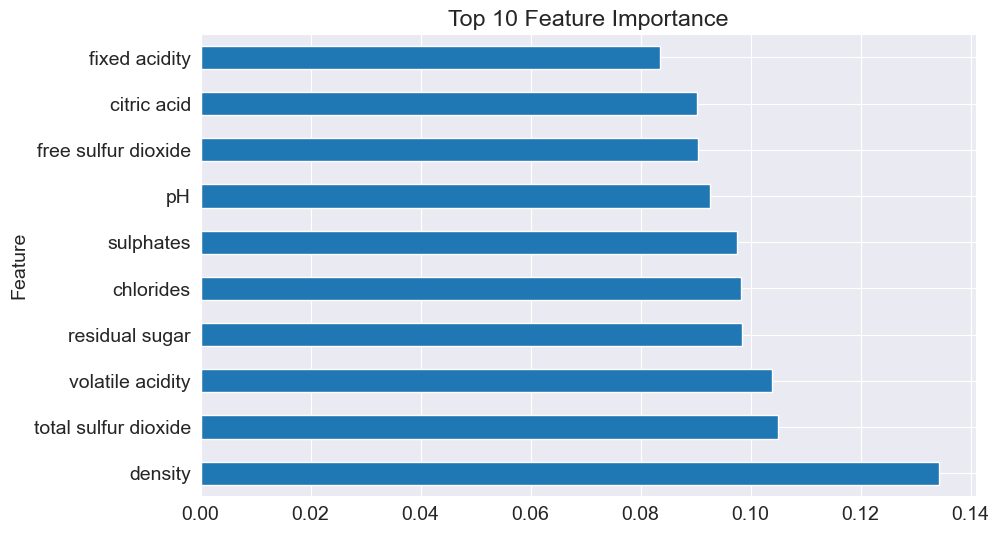

In [112]:
importance = model.feature_importances_
feature_names = X_train.columns

# Visualizing feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

import matplotlib.pyplot as plt
importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Top 10 Feature Importance')
plt.show()

Let's visualize the correlation matrix using a heatmap

Text(0.5, 1.0, 'Correlation Matrix')

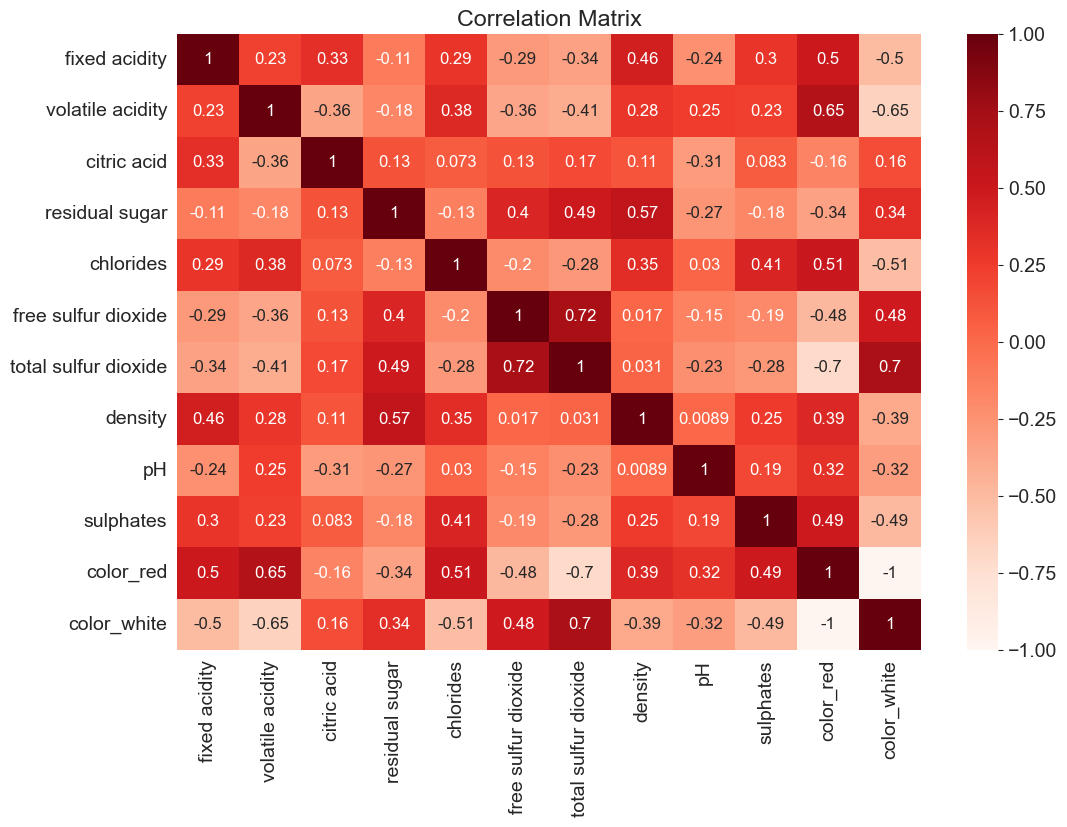

In [114]:
plt.figure(figsize=(12, 8))  # Increase figure size for more space
sns.heatmap(X_train.corr(), cmap='Reds', annot=True, annot_kws={"size": 12}) 
plt.title('Correlation Matrix')

In [123]:
a = X_val.drop("free sulfur dioxide", axis=1)

We attempt droppoing "free sulfur dioxide" column. "free sulfur dioxide" and "total sulfur dioxide" are highly correlated from the correlation matrix. it may be useful to drop one to reduce multicollinearity

In [ ]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth = None, min_samples_split= 2, n_estimators=500)    # Using the parameters obtained after hyperparameter tuning
model.fit(X_val, val_targets)
val_score = model.score(X_val, val_targets)
print("Validation Accuracy: ", val_score)


Validation Accuracy:  1.0
